In [1]:
#@title Install modules
!git clone https://github.com/openai/CLIP
!pip install taming-transformers
!git clone https://github.com/CompVis/taming-transformers.git
!pip install ftfy regex tqdm omegaconf pytorch-lightning
!pip install kornia
!pip install imageio-ffmpeg   
!pip install einops          
!mkdir steps

fatal: destination path 'CLIP' already exists and is not an empty directory.
fatal: destination path 'taming-transformers' already exists and is not an empty directory.
  Using cached einops-0.3.2-py3-none-any.whl (25 kB)


In [5]:
#@title Select of model to download
#@markdown Choose only 1.

imagenet_1024 = False #@param {type:"boolean"}
imagenet_16384 = False #@param {type:"boolean"}
coco = False #@param {type:"boolean"}
faceshq = False #@param {type:"boolean"}
wikiart_1024 = False #@param {type:"boolean"}
wikiart_16384 = False #@param {type:"boolean"}
sflckr = True #@param {type:"boolean"}
openimages_8192 = False #@param {type:"boolean"}

if imagenet_1024:
  !curl -L -o vqgan_imagenet_f16_1024.yaml -C - 'http://mirror.io.community/blob/vqgan/vqgan_imagenet_f16_1024.yaml' #ImageNet 1024
  !curl -L -o vqgan_imagenet_f16_1024.ckpt -C - 'http://mirror.io.community/blob/vqgan/vqgan_imagenet_f16_1024.ckpt'  #ImageNet 1024
if imagenet_16384:
  !curl -L -o vqgan_imagenet_f16_16384.yaml -C - 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' #ImageNet 16384
  !curl -L -o vqgan_imagenet_f16_16384.ckpt -C - 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fckpts%2Flast.ckpt&dl=1' #ImageNet 16384

if openimages_8192:
  !curl -L -o vqgan_openimages_f16_8192.yaml -C - 'https://heibox.uni-heidelberg.de/d/2e5662443a6b4307b470/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' #ImageNet 16384
  !curl -L -o vqgan_openimages_f16_8192.ckpt -C - 'https://heibox.uni-heidelberg.de/d/2e5662443a6b4307b470/files/?p=%2Fckpts%2Flast.ckpt&dl=1' #ImageNet 16384

if coco:
  !curl -L -o coco.yaml -C - 'https://dl.nmkd.de/ai/clip/coco/coco.yaml' #COCO
  !curl -L -o coco.ckpt -C - 'https://dl.nmkd.de/ai/clip/coco/coco.ckpt' #COCO
if faceshq:
  !curl -L -o faceshq.yaml -C - 'https://drive.google.com/uc?export=download&id=1fHwGx_hnBtC8nsq7hesJvs-Klv-P0gzT' #FacesHQ
  !curl -L -o faceshq.ckpt -C - 'https://app.koofr.net/content/links/a04deec9-0c59-4673-8b37-3d696fe63a5d/files/get/last.ckpt?path=%2F2020-11-13T21-41-45_faceshq_transformer%2Fcheckpoints%2Flast.ckpt' #FacesHQ
if wikiart_1024: 
  !curl -L -o wikiart_1024.yaml -C - 'https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' #WikiArt 1024
  !curl -L -o wikiart_1024.ckpt -C - 'https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fckpts%2Flast.ckpt&dl=1' #WikiArt 1024
if wikiart_16384: 
  !curl -L -o wikiart_16384.yaml -C - 'http://eaidata.bmk.sh/data/Wikiart_16384/wikiart_f16_16384_8145600.yaml' #WikiArt 16384
  !curl -L -o wikiart_16384.ckpt -C - 'http://eaidata.bmk.sh/data/Wikiart_16384/wikiart_f16_16384_8145600.ckpt' #WikiArt 16384
if sflckr:
  !curl -L -o sflckr.yaml -C - 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fconfigs%2F2020-11-09T13-31-51-project.yaml&dl=1' #S-FLCKR
  !curl -L -o sflckr.ckpt -C - 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fcheckpoints%2Flast.ckpt&dl=1' #S-FLCKR

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1603  100  1603    0     0   1582      0  0:00:01  0:00:01 --:--:--     0
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 4066M  100 4066M    0     0  4467k      0  0:15:32  0:15:32 --:--:-- 2219k
curl: (16) Error in the HTTP2 framing layer


In [6]:
# @title Load libraries and variables

import argparse
import math
from pathlib import Path
import sys

sys.path.insert(1, '/content/taming-transformers')
from IPython import display
from base64 import b64encode
from omegaconf import OmegaConf
from PIL import Image
from taming.models import cond_transformer, vqgan
import taming.modules 
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm
import plotly.express as px
from CLIP import clip
import kornia.augmentation as K
import numpy as np
import matplotlib.pyplot as plt
import imageio
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))


def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()


def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]


def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size

    input = input.view([n * c, 1, h, w])

    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])

    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])

    input = input.view([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)


class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward

    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)


replace_grad = ReplaceGrad.apply


class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)

    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None


clamp_with_grad = ClampWithGrad.apply


def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)


class Prompt(nn.Module):
    def __init__(self, embed, weight=1., stop=float('-inf')):
        super().__init__()
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))

    def forward(self, input):
        input_normed = F.normalize(input.unsqueeze(1), dim=2)
        embed_normed = F.normalize(self.embed.unsqueeze(0), dim=2)
        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        return self.weight.abs() * replace_grad(dists, torch.maximum(dists, self.stop)).mean()


def parse_prompt(prompt):
    vals = prompt.rsplit(':', 2)
    vals = vals + ['', '1', '-inf'][len(vals):]
    return vals[0], float(vals[1]), float(vals[2])


class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

        self.augs = nn.Sequential(
            # K.RandomHorizontalFlip(p=0.5),
            # K.RandomVerticalFlip(p=0.5),
            # K.RandomSolarize(0.01, 0.01, p=0.7),
            # K.RandomSharpness(0.3,p=0.4),
            # K.RandomResizedCrop(size=(self.cut_size,self.cut_size), scale=(0.1,1),  ratio=(0.75,1.333), cropping_mode='resample', p=0.5),
            # K.RandomCrop(size=(self.cut_size,self.cut_size), p=0.5),
            K.RandomAffine(degrees=15, translate=0.1, p=0.7, padding_mode='border'),
            K.RandomPerspective(0.7,p=0.7),
            K.ColorJitter(hue=0.1, saturation=0.1, p=0.7),
            K.RandomErasing((.1, .4), (.3, 1/.3), same_on_batch=True, p=0.7),
            
)
        self.noise_fac = 0.1
        self.av_pool = nn.AdaptiveAvgPool2d((self.cut_size, self.cut_size))
        self.max_pool = nn.AdaptiveMaxPool2d((self.cut_size, self.cut_size))

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        
        for _ in range(self.cutn):

            # size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            # offsetx = torch.randint(0, sideX - size + 1, ())
            # offsety = torch.randint(0, sideY - size + 1, ())
            # cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            # cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))

            # cutout = transforms.Resize(size=(self.cut_size, self.cut_size))(input)
            
            cutout = (self.av_pool(input) + self.max_pool(input))/2
            cutouts.append(cutout)
        batch = self.augs(torch.cat(cutouts, dim=0))
        if self.noise_fac:
            facs = batch.new_empty([self.cutn, 1, 1, 1]).uniform_(0, self.noise_fac)
            batch = batch + facs * torch.randn_like(batch)
        return batch


def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.vqgan.GumbelVQ':
        model = vqgan.GumbelVQ(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model


def resize_image(image, out_size):
    ratio = image.size[0] / image.size[1]
    area = min(image.size[0] * image.size[1], out_size[0] * out_size[1])
    size = round((area * ratio)**0.5), round((area / ratio)**0.5)
    return image.resize(size, Image.LANCZOS)



/usr/local/lib/python3.7/dist-packages/plotly/express/_doc.py:503: DeprecationWarning:

inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()

/usr/local/lib/python3.7/dist-packages/plotly/express/_doc.py:503: DeprecationWarning:

inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()

/usr/local/lib/python3.7/dist-packages/plotly/express/_doc.py:503: DeprecationWarning:

inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()

/usr/local/lib/python3.7/dist-packages/plotly/express/_doc.py:503: DeprecationWarning:

inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()

/usr/local/lib/python3.7/dist-packages/plotly/express/_doc.py:503: DeprecationWarning:

inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()

/usr/local/lib/python3.7/dist-

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from sflckr.ckpt
i: 0, Sumloss: 0.936519, losses: 0.936519


i: 5, Sumloss: 0.930141, losses: 0.930141


i: 10, Sumloss: 0.911349, losses: 0.911349


i: 15, Sumloss: 0.93439, losses: 0.93439


i: 20, Sumloss: 0.89778, losses: 0.89778


i: 25, Sumloss: 0.897, losses: 0.897


i: 30, Sumloss: 0.912362, losses: 0.912362


i: 35, Sumloss: 0.877765, losses: 0.877765


i: 40, Sumloss: 0.875919, losses: 0.875919


i: 45, Sumloss: 0.876295, losses: 0.876295


i: 50, Sumloss: 0.883426, losses: 0.883426


i: 55, Sumloss: 0.874786, losses: 0.874786


i: 60, Sumloss: 0.904181, losses: 0.904181


i: 65, Sumloss: 0.875989, losses: 0.875989


i: 70, Sumloss: 0.861909, losses: 0.861909


i: 75, Sumloss: 0.877986, losses: 0.877986


i: 80, Sumloss: 0.88269, losses: 0.88269


i: 85, Sumloss: 0.883711, losses: 0.883711


i: 90, Sumloss: 0.865515, losses: 0.865515


i: 95, Sumloss: 0.874335, losses: 0.874335


i: 100, Sumloss: 0.88765, losses: 0.88765


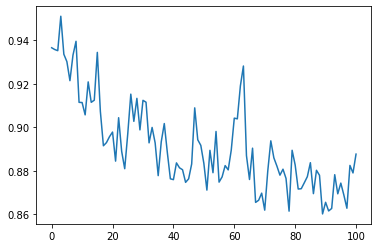

i: 0, Sumloss: 0.90278, losses: 0.90278


i: 5, Sumloss: 0.908068, losses: 0.908068


i: 10, Sumloss: 0.939573, losses: 0.939573


i: 15, Sumloss: 0.950412, losses: 0.950412


i: 20, Sumloss: 0.941692, losses: 0.941692


i: 25, Sumloss: 0.926001, losses: 0.926001


i: 30, Sumloss: 0.927383, losses: 0.927383


i: 35, Sumloss: 0.914125, losses: 0.914125


i: 40, Sumloss: 0.911083, losses: 0.911083


i: 45, Sumloss: 0.928432, losses: 0.928432


i: 50, Sumloss: 0.928095, losses: 0.928095


i: 55, Sumloss: 0.894352, losses: 0.894352


i: 60, Sumloss: 0.902074, losses: 0.902074


i: 65, Sumloss: 0.916015, losses: 0.916015


i: 70, Sumloss: 0.923996, losses: 0.923996


i: 75, Sumloss: 0.914359, losses: 0.914359


i: 80, Sumloss: 0.923004, losses: 0.923004


i: 85, Sumloss: 0.924336, losses: 0.924336


i: 90, Sumloss: 0.938922, losses: 0.938922


i: 95, Sumloss: 0.916567, losses: 0.916567


i: 100, Sumloss: 0.90577, losses: 0.90577


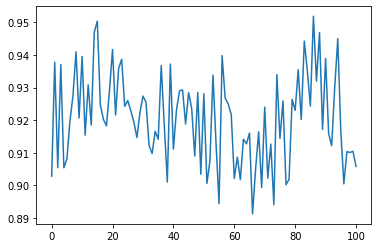

i: 0, Sumloss: 0.886109, losses: 0.886109


i: 50, Sumloss: 0.889153, losses: 0.889153


i: 100, Sumloss: 0.875623, losses: 0.875623


i: 150, Sumloss: 0.884987, losses: 0.884987


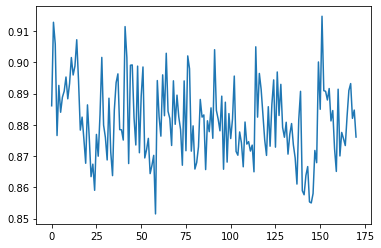

In [9]:

#@title User input parameters
#@markdown Place the text or texts you want to generate (separated with |). It is a list because you can put more than one text, and so the AI ​​tries to 'mix' the images, giving the same priority to both texts. If using multiple text prompts, including a relative weighting can be useful. Ensure the model selected is the same as the model downloaded. ------------------------------------------------------------------------------------------------------------------------------
#@markdown Eg. a snowy landscape with trees:100 | watercolour painting:20
texts = "red octopus #pixelart" #@param {type:"string"}
width =  32#@param {type:"number"}
height = 32#@param {type:"number"}
model = "sflckr" #@param ["vqgan_imagenet_f16_16384", "vqgan_imagenet_f16_1024", "vqgan_openimages_f16_8192", "wikiart_1024", "wikiart_16384", "coco", "faceshq", "sflckr"]
#@markdown custom seeds
seeds = []
seed1 = "/content/pixelNoise.png"#@param {type:"string"}
seeds.append(seed1)
seed2 = "/content/centralPixelNoise.png"#@param {type:"string"}
seeds.append(seed2)



#@markdown Use this code box to execute the algorithm.

images_interval =  5 #setting this high avoids a checkin
init_image = ""
target_images = ""
#seed = 1
max_iterations = 100 #sets how many intial iterations for each different seed

model_names={"vqgan_imagenet_f16_16384": 'ImageNet 16384',"vqgan_imagenet_f16_1024":"ImageNet 1024", 'vqgan_openimages_f16_8192':'OpenImages 8912',
                 "wikiart_1024":"WikiArt 1024", "wikiart_16384":"WikiArt 16384", "coco":"COCO-Stuff", "faceshq":"FacesHQ", "sflckr":"S-FLCKR"}
name_model = model_names[model] 


if init_image == "None":
    init_image = None
if target_images == "None" or not target_images:
    target_images = []
else:
    target_images = target_images.split("|")
    target_images = [image.strip() for image in target_images]

texts = [phrase.strip() for phrase in texts.split("|")]
if texts == ['']:
    texts = []

args = argparse.Namespace(
    prompts=texts,
    image_prompts=target_images,
    noise_prompt_seeds=[],
    noise_prompt_weights=[],
    size=[width, height],
    init_image=init_image,
    init_weight=0.,
    clip_model='ViT-B/32',
    vqgan_config=f'{model}.yaml',
    vqgan_checkpoint=f'{model}.ckpt',
    step_size=0.05,
    cutn=32,
    cut_pow=1.,
    display_freq=images_interval
)


# start execution__________________________________________________________________________________________

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



model = load_vqgan_model(args.vqgan_config, args.vqgan_checkpoint).to(device)
perceptor = clip.load(args.clip_model, jit=False)[0].eval().requires_grad_(False).to(device)

cut_size = perceptor.visual.input_resolution
e_dim = model.quantize.e_dim
f = 2**(model.decoder.num_resolutions - 1)
make_cutouts = MakeCutouts(cut_size, args.cutn, cut_pow=args.cut_pow)
n_toks = model.quantize.n_e
toksX, toksY = args.size[0] // f, args.size[1] // f
sideX, sideY = toksX * f, toksY * f
z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]



normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                 std=[0.26862954, 0.26130258, 0.27577711])

pMs = []

for prompt in args.prompts:
    txt, weight, stop = parse_prompt(prompt)
    embed = perceptor.encode_text(clip.tokenize(txt).to(device)).float()
    pMs.append(Prompt(embed, weight, stop).to(device))

for prompt in args.image_prompts:
    path, weight, stop = parse_prompt(prompt)
    img = resize_image(Image.open(path).convert('RGB'), (sideX, sideY))
    batch = make_cutouts(TF.to_tensor(img).unsqueeze(0).to(device))
    embed = perceptor.encode_image(normalize(batch)).float()
    pMs.append(Prompt(embed, weight, stop).to(device))


def synth(z):
    z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
    return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)


@torch.no_grad()
def checkin(i, losses):
    losses_str = ', '.join(f'{loss.item():g}' for loss in losses)
    tqdm.write(f'i: {i}, Sumloss: {sum(losses).item():g}, losses: {losses_str}')
    out = synth(z)
    img = np.array(out.mul(255).clamp(0, 255)[0].cpu().detach().numpy().astype(np.uint8))[:,:,:]
    img = np.transpose(img, (1, 2, 0))
    fig = px.imshow(img)
    fig.show()

def ascend_txt():
    global i
    out = synth(z)
    iii = perceptor.encode_image(normalize(make_cutouts(out))).float()
    
    result = []

    if args.init_weight:
        # result.append(F.mse_loss(z, z_orig) * args.init_weight / 2)
        result.append(F.mse_loss(z, torch.zeros_like(z_orig)) * ((1/torch.tensor(i*2 + 1))*args.init_weight) / 2)
    for prompt in pMs:
        result.append(prompt(iii))
    img = np.array(out.mul(255).clamp(0, 255)[0].cpu().detach().numpy().astype(np.uint8))[:,:,:]
    img = np.transpose(img, (1, 2, 0))

    return result

def train(i):
    opt.zero_grad()
    lossAll = ascend_txt()
    if i % args.display_freq == 0:
        checkin(i, lossAll)
       
    loss = sum(lossAll)
    loss.backward()
    opt.step()
    with torch.no_grad():
        z.copy_(z.maximum(z_min).minimum(z_max))

    return loss

finalLoss = []
seedIndex = 0
for seed in seeds:
  
    pil_image = Image.open(seed).convert('RGB')
    pil_image = pil_image.resize((sideX, sideY), Image.LANCZOS)
    z, *_ = model.encode(TF.to_tensor(pil_image).to(device).unsqueeze(0) * 2 - 1)
    z_orig = z.clone()
    z.requires_grad_(True)  
    opt = optim.Adam([z], lr=args.step_size)

    # TRY WITHOUT THIS SOON
    for seed, weight in zip(args.noise_prompt_seeds, args.noise_prompt_weights):
        gen = torch.Generator().manual_seed(seed)
        embed = torch.empty([1, perceptor.visual.output_dim]).normal_(generator=gen)
        pMs.append(Prompt(embed, weight).to(device))

    i = 0
    iArr = []
    lossArr = []
    try:
        while True:
            lossTemp = train(i)
            iArr.append(i)
            lossArr.append(lossTemp.item())
        
            if i == max_iterations:
                img = np.array(synth(z).mul(255).clamp(0, 255)[0].cpu().detach().numpy().astype(np.uint8))[:,:,:]
                img = np.transpose(img, (1, 2, 0))
                imageio.imwrite('./steps/' + 'seed' + str(seedIndex) + '.png', np.array(img))
                finalLoss.append(min(lossArr))
                seedIndex += 1
                break
            i += 1
            
    except KeyboardInterrupt:
        pass

    plt.plot(iArr,lossArr)
    plt.show()

    # "human" image decriminator function
    # try averaging??
    




# SECOND STAGE: further development of best seed____________________________________________________________
bestSeed = finalLoss.index(min(finalLoss))

images_interval =  50
init_image = "./steps/seed" + str(bestSeed) + '.png'
max_iterations = 1000 #sets how many intial iterations for each different seed

args = argparse.Namespace(
    prompts=texts,
    image_prompts=target_images,
    noise_prompt_seeds=[],
    noise_prompt_weights=[],
    size=[width, height],
    init_image=init_image,
    init_weight=0.,
    clip_model='ViT-B/32',
    vqgan_config=f'{model}.yaml',
    vqgan_checkpoint=f'{model}.ckpt',
    step_size=0.05,
    cutn=32,
    cut_pow=1.,
    display_freq=images_interval,
    seed=seed,
)

pil_image = Image.open(args.init_image).convert('RGB')
pil_image = pil_image.resize((sideX, sideY), Image.LANCZOS)
z, *_ = model.encode(TF.to_tensor(pil_image).to(device).unsqueeze(0) * 2 - 1)

z_orig = z.clone()
z.requires_grad_(True)
opt = optim.Adam([z], lr=args.step_size)

normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                 std=[0.26862954, 0.26130258, 0.27577711])

pMs = []

for prompt in args.prompts:
    txt, weight, stop = parse_prompt(prompt)
    embed = perceptor.encode_text(clip.tokenize(txt).to(device)).float()
    pMs.append(Prompt(embed, weight, stop).to(device))

for prompt in args.image_prompts:
    path, weight, stop = parse_prompt(prompt)
    img = resize_image(Image.open(path).convert('RGB'), (sideX, sideY))
    batch = make_cutouts(TF.to_tensor(img).unsqueeze(0).to(device))
    embed = perceptor.encode_image(normalize(batch)).float()
    pMs.append(Prompt(embed, weight, stop).to(device))


i = 0
iArr = []
lossArr = []
try:

    while True:
        loss = train(i)
        iArr.append(i)
        lossArr.append(loss.item())
        
        if i == max_iterations:
            img = np.array(out.mul(255).clamp(0, 255)[0].cpu().detach().numpy().astype(np.uint8))[:,:,:]
            img = np.transpose(img, (1, 2, 0))
            imageio.imwrite('./steps/' + 'final.png', np.array(img))
            break
        i += 1
            
except KeyboardInterrupt:
    pass

plt.plot(iArr,lossArr)
plt.show()

